In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.dummy import DummyClassifier

from datetime import datetime
from tqdm import tqdm
import yaml
import joblib
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import hashlib

# Load Dataset

In [70]:
x_train = joblib.load("data/raw/x_train.pkl")
y_train = joblib.load("data/raw/y_train.pkl")

x_rus = joblib.load("data/processed/x_rus.pkl")
y_rus = joblib.load("data/processed/y_rus.pkl")

x_ros = joblib.load("data/processed/x_ros.pkl")
y_ros = joblib.load("data/processed/y_ros.pkl")

x_sm = joblib.load("data/processed/x_sm.pkl")
y_sm = joblib.load("data/processed/y_sm.pkl")

x_valid = joblib.load("data/processed/x_valid_feng.pkl")
y_valid = joblib.load("data/processed/y_valid_feng.pkl")

x_test = joblib.load("data/processed/x_test_feng.pkl")
y_test = joblib.load("data/processed/y_test_feng.pkl")

# Log Template

In [71]:
def time_stamp():
    return datetime.now()

In [72]:
def create_log_template():
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "f1_score_avg" : [],
        "data_configurations" : [],
    }

    return logger

In [73]:
def training_log_updater(current_log, log_path):
    current_log = current_log.copy()

    try:
        with open(log_path, "r") as file: #read
            last_log = json.load(file)
        file.close()
    except FileNotFoundError as ffe:
        with open(log_path, "w") as file: #write
            file.write("[]")
        file.close()
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    last_log.append(current_log)

    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    return last_log

## Baseline Model

### Label Encoding

In [74]:
le_deposit = joblib.load("model/le_deposit.pkl")

In [75]:
y_train = le_deposit.transform(y_train)
y_train

array([0, 0, 1, ..., 0, 0, 1])

In [76]:
# create dummy classifier
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
# train a model
dummy_clf.fit(x_train, y_train)
# get accuracy score
baseline_score = dummy_clf.score(x_test, y_test)
baseline_score

0.5261979399910435

# Training & Evaluation

## Create Model Object 

In [77]:
def training_log_updater(current_log, log_path):
    current_log = current_log.copy()

    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    except FileNotFoundError as ffe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    last_log.append(current_log)

    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    return last_log

In [78]:
lgr_baseline = LogisticRegression()
dct_baseline = DecisionTreeClassifier()
rfc_baseline = RandomForestClassifier()
knn_baseline = KNeighborsClassifier()
xgb_baseline = XGBClassifier()

In [79]:
list_of_model = {
    "undersampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "oversampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "smote" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    }

## Training Model

In [80]:
def train_eval_model(list_of_model, prefix_model_name, x_train, y_train, data_configuration_name, x_valid, y_valid, log_path):

    list_of_model = copy.deepcopy(list_of_model)
    logger = create_log_template()

    for model in tqdm(list_of_model):    
        model_name = prefix_model_name + "-" + model["model_name"]

        #fit
        start_time = time_stamp()
        model["model_object"].fit(x_train, y_train)
        finished_time = time_stamp()

        # convert ke second
        elapsed_time = finished_time - start_time
        elapsed_time = elapsed_time.total_seconds()
        

        # using predict x_valid (x_test masih disimpen)
        y_pred = model["model_object"].predict(x_valid)
        performance = classification_report(y_valid, y_pred, output_dict = True)

        # make uid (one way encryption)
        plain_id = str(start_time) + str(finished_time)
        chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

        model["model_uid"] = chiper_id

        # append
        logger["model_name"].append(model_name)
        logger["model_uid"].append(chiper_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["performance"].append(performance)
        logger["f1_score_avg"].append(performance["macro avg"]["f1-score"]) # pake recall
        logger["data_configurations"].append(data_configuration_name)

    training_log = training_log_updater(logger, log_path)

    return training_log, list_of_model

### Baseline Model Undersampling

In [81]:
training_log, list_of_model_rus = train_eval_model(
    list_of_model["undersampling"],
    "baseline_model",
    x_rus,
    y_rus,
    "undersampling",
    x_valid,
    y_valid,
    "log/training_log.json"
)

  0%|                                                     | 0/5 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 80%|████████████████████████████████████         | 4/5 [00:01<00:00,  2.88it/s]/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (

[13:31:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


In [82]:
list_of_model["undersampling"] = copy.deepcopy(list_of_model_rus)

### Baseline Model Oversampling

In [83]:
training_log, list_of_model_ros = train_eval_model(
    list_of_model["oversampling"],
    "baseline_model",
    x_rus,
    y_rus,
    "oversampling",
    x_valid,
    y_valid,
    "log/training_log.json"
)

  0%|                                                     | 0/5 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 80%|████████████████████████████████████         | 4/5 [00:01<00:00,  2.16it/s]/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (

[13:31:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


In [84]:
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)

### Baseline Model SMOTE

In [85]:
training_log, list_of_model_sm = train_eval_model(
    list_of_model["smote"],
    "baseline_model",
    x_rus,
    y_rus,
    "smote",
    x_valid,
    y_valid,
    "log/training_log.json"
)

  0%|                                                     | 0/5 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 80%|████████████████████████████████████         | 4/5 [00:01<00:00,  3.04it/s]/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (

[13:31:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


In [86]:
list_of_model["smote"] = copy.deepcopy(list_of_model_sm)

## Best Performance

In [87]:
def training_log_to_df(training_log):
    training_res = pd.DataFrame()

    for log in tqdm(training_log):
        training_res = pd.concat([training_res, pd.DataFrame(log)])
    
    training_res.sort_values(["f1_score_avg", "training_time"], ascending = [False, True], inplace = True)
    training_res.reset_index(inplace = True, drop = True)
    
    return training_res

In [88]:
training_res = training_log_to_df(training_log)

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 223.88it/s]


In [89]:
training_res

,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configurations
0,baseline_model-RandomForestClassifier,5dbfa206a77061466bd9f994810ef967,1.030421,2023-04-09 13:31:31.690548,"{'0': {'precision': 0.865158371040724, 'recall...",0.835501,oversampling
1,baseline_model-RandomForestClassifier,b19070484136de43e7b810ef043a0b47,0.787562,2023-04-09 13:31:34.643479,"{'0': {'precision': 0.860909090909091, 'recall...",0.829689,smote
2,baseline_model-RandomForestClassifier,809bbc6b9ccc0fc3bb7d6aa26609b029,0.833991,2023-04-09 13:31:28.729670,"{'0': {'precision': 0.8563685636856369, 'recal...",0.827426,undersampling
3,baseline_model-XGBClassifier,ca8c4e7cb1d47520fbc0cab822631daf,0.901862,2023-04-09 13:31:35.749003,"{'0': {'precision': 0.8567518248175182, 'recal...",0.824322,smote
4,baseline_model-XGBClassifier,cf5186c9d28ec4e5092a983e36597d06,1.038832,2023-04-09 13:31:29.855856,"{'0': {'precision': 0.8567518248175182, 'recal...",0.824322,undersampling
5,baseline_model-XGBClassifier,6d1d4aff85bc1fe3fe8e37e4caec767a,1.155388,2023-04-09 13:31:33.013269,"{'0': {'precision': 0.8567518248175182, 'recal...",0.824322,oversampling
6,baseline_model-LogisticRegression,dc54f227392b5c8747a12a1fa7663fec,0.104610,2023-04-09 13:31:34.453203,"{'0': {'precision': 0.8106255355612683, 'recal...",0.798354,smote
7,baseline_model-LogisticRegression,87103db946c09c881474b93d6221a5d3,0.199152,2023-04-09 13:31:28.440427,"{'0': {'precision': 0.8106255355612683, 'recal...",0.798354,undersampling
8,baseline_model-LogisticRegression,6cc74c00bc9903c04bd8da02cf6d5691,0.212778,2023-04-09 13:31:31.242912,"{'0': {'precision': 0.8106255355612683, 'recal...",0.798354,oversampling
9,baseline_model-DecisionTreeClassifier,fe6ace821d4173465c1c2f0a5cdde0ab,0.057961,2023-04-09 13:31:34.571221,"{'0': {'precision': 0.7774822695035462, 'recal...",0.754239,smote


In [90]:
def get_best_model(training_log_df, list_of_model):
    model_object = None

    # pick the highest one
    best_model_info = training_log_df.sort_values(["f1_score_avg", "training_time"], ascending = [False, True]).iloc[0]
    
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_info["model_uid"]:
                model_object = model_data["model_object"]
                break
    
    if model_object == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    return model_object
    

In [91]:
model = get_best_model(training_res, list_of_model)

In [92]:
model

RandomForestClassifier()

In [93]:
joblib.dump(model, "model/model.pkl")

['model/model.pkl']

### Hyperparameter Tuning

In [94]:
params_rf = {
    "n_estimators" : [5,7,12,21],
    "max_depth" : [2,3,6,16,17,30],
    "min_samples_split" : [4,6,22,29],
    "min_samples_leaf" : [6,7,12,28,32]
}

In [95]:
rf_param = GridSearchCV(RandomForestClassifier(),
                        params_rf)

In [96]:
list_of_model["undersampling"].append({"model_name": rf_param.__class__.__name__ + "-" + rf_param.estimator.__class__.__name__, "model_object": copy.deepcopy(rf_param), "model_uid": ""})
list_of_model["oversampling"].append({"model_name": rf_param.__class__.__name__ + "-" + rf_param.estimator.__class__.__name__, "model_object": copy.deepcopy(rf_param), "model_uid": ""})
list_of_model["smote"].append({"model_name": rf_param.__class__.__name__ + "-" + rf_param.estimator.__class__.__name__, "model_object": copy.deepcopy(rf_param), "model_uid": ""})

In [97]:
training_log, list_of_model_sm_hyp = train_eval_model(
    [list_of_model["smote"][-1]], # newest
    "hyperparams",
    x_sm,
    y_sm,
    "smote",
    x_valid,
    y_valid,
    "log/training_log.json"
)

100%|████████████████████████████████████████████| 1/1 [02:15<00:00, 135.66s/it]


In [99]:
list_of_model["smote"][-1] = copy.deepcopy(list_of_model_sm_hyp[0])

In [100]:
list_of_model["smote"][-1]

{'model_name': 'GridSearchCV-RandomForestClassifier',
 'model_object': GridSearchCV(estimator=RandomForestClassifier(),
              param_grid={'max_depth': [2, 3, 6, 16, 17, 30],
                          'min_samples_leaf': [6, 7, 12, 28, 32],
                          'min_samples_split': [4, 6, 22, 29],
                          'n_estimators': [5, 7, 12, 21]}),
 'model_uid': '7c7faec9465ed52e563eea60c278aa8b'}

In [101]:
training_log_to_df(training_log)

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 346.83it/s]


,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configurations
0,baseline_model-RandomForestClassifier,5dbfa206a77061466bd9f994810ef967,1.030421,2023-04-09 13:31:31.690548,"{'0': {'precision': 0.865158371040724, 'recall...",0.835501,oversampling
1,hyperparams-GridSearchCV-RandomForestClassifier,7c7faec9465ed52e563eea60c278aa8b,135.637004,2023-04-09 13:31:37.454950,"{'0': {'precision': 0.8656307129798904, 'recal...",0.832394,smote
2,baseline_model-RandomForestClassifier,b19070484136de43e7b810ef043a0b47,0.787562,2023-04-09 13:31:34.643479,"{'0': {'precision': 0.860909090909091, 'recall...",0.829689,smote
3,baseline_model-RandomForestClassifier,809bbc6b9ccc0fc3bb7d6aa26609b029,0.833991,2023-04-09 13:31:28.729670,"{'0': {'precision': 0.8563685636856369, 'recal...",0.827426,undersampling
4,baseline_model-XGBClassifier,ca8c4e7cb1d47520fbc0cab822631daf,0.901862,2023-04-09 13:31:35.749003,"{'0': {'precision': 0.8567518248175182, 'recal...",0.824322,smote
5,baseline_model-XGBClassifier,cf5186c9d28ec4e5092a983e36597d06,1.038832,2023-04-09 13:31:29.855856,"{'0': {'precision': 0.8567518248175182, 'recal...",0.824322,undersampling
6,baseline_model-XGBClassifier,6d1d4aff85bc1fe3fe8e37e4caec767a,1.155388,2023-04-09 13:31:33.013269,"{'0': {'precision': 0.8567518248175182, 'recal...",0.824322,oversampling
7,baseline_model-LogisticRegression,dc54f227392b5c8747a12a1fa7663fec,0.104610,2023-04-09 13:31:34.453203,"{'0': {'precision': 0.8106255355612683, 'recal...",0.798354,smote
8,baseline_model-LogisticRegression,87103db946c09c881474b93d6221a5d3,0.199152,2023-04-09 13:31:28.440427,"{'0': {'precision': 0.8106255355612683, 'recal...",0.798354,undersampling
9,baseline_model-LogisticRegression,6cc74c00bc9903c04bd8da02cf6d5691,0.212778,2023-04-09 13:31:31.242912,"{'0': {'precision': 0.8106255355612683, 'recal...",0.798354,oversampling


## Confusion Matrix

In [102]:
y_pred = model.predict(x_valid)

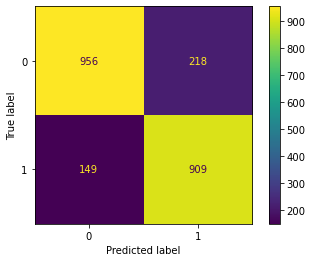

In [103]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)

## Classification Report

In [104]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1174
           1       0.81      0.86      0.83      1058

    accuracy                           0.84      2232
   macro avg       0.84      0.84      0.84      2232
weighted avg       0.84      0.84      0.84      2232



In [105]:
baseline_score

0.5261979399910435

## Evaluate with test data

In [106]:
y_pred2 = model.predict(x_test)

In [107]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.85      0.80      0.82      1175
           1       0.79      0.85      0.82      1058

    accuracy                           0.82      2233
   macro avg       0.82      0.82      0.82      2233
weighted avg       0.82      0.82      0.82      2233

